# Plot vowels

Let's use Python to plot our extracted formant vowels and inspect our vowels spaces.
We'll start with a very simple figure, where we simply plot the raw F1 and F2 frequencies for the cardinal vowels.
Things to notice:
1. We need to import libraries
2. We use `pandas` to import and structure our data
3. We use `seaborn` to make plotting easier
4. We use `matplotlib.pyplot` to make adjustments to our figure
5. We rename libraries with abreviations

In [5]:
# import data structuring and plotting libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# quiet warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Read our txt file into a pandas dataframe
df = pd.read_csv('/Users/ethan/Documents/praat_tutorial_tempfiles/h_d_raw/formants/combined_formants.txt', sep='\t')


# inspect the first 5 lines
df

,Interval,Label,Start,End,Duration,F1,F2,F3,Source_File
0,2,Segment_1,0.218,0.530,0.312,244.8,2096.7,2810.6,h_d_AmEng1_formants
1,4,Segment_2,1.098,1.450,0.352,295.4,1998.6,2687.1,h_d_AmEng1_formants
2,6,Segment_3,2.250,2.570,0.320,348.4,1888.2,2692.2,h_d_AmEng1_formants
3,8,Segment_4,3.186,3.546,0.360,466.3,1821.8,2604.2,h_d_AmEng1_formants
4,10,Segment_5,4.162,4.498,0.336,447.5,1293.4,2574.8,h_d_AmEng1_formants
...,...,...,...,...,...,...,...,...,...
67,8,Segment_4,6.441,6.769,0.328,597.1,1488.1,2593.8,h_d_ScEng_formants
68,10,Segment_5,7.785,8.049,0.264,359.4,1180.7,2698.6,h_d_ScEng_formants
69,12,Segment_6,9.073,9.409,0.336,433.7,1365.2,2791.0,h_d_ScEng_formants
70,14,Segment_7,10.417,10.633,0.216,307.7,1658.4,2569.6,h_d_ScEng_formants


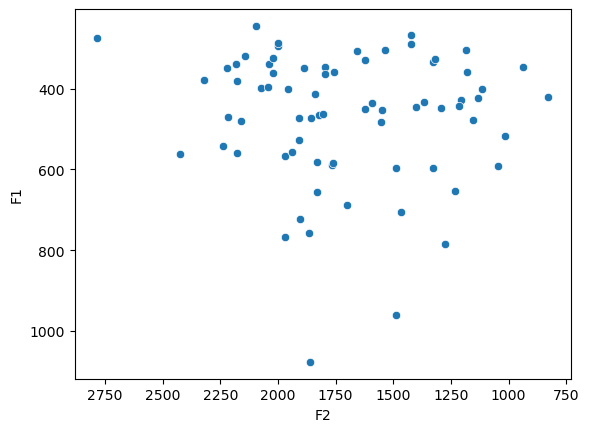

In [7]:
ax = sns.scatterplot(data=df, x=df['F2'], y=df['F1'])
ax.invert_yaxis()
ax.invert_xaxis()

## Fancier vowel plots using helper functions

The vowelplot, barkify, and Lobify functions below were written by [Emily Remirez](https://sites.google.com/berkeley.edu/eremirez/) and copied from: [Linguistics Methods Hub: Vowel plotting in Python](https://lingmethodshub.github.io/content/python/vowel-plotting-py/index.html).

Using Emily's functions, we can quickly and easily make professional-looking vowel plots for comparing speakers, dialects, or languages.


In [8]:
# vowelplot function
# written by Emily Remirez
# small modification to remove left and right spines by Ethan Weed

import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

def vowelplot (vowelcsv, color=None, F1="F1", F2="F2", vowel="Vowel", title="Vowel Plot", unit="Hz", logscale=True):

    #Set some parameters for the chart itself
    sns.set(style='ticks', context='notebook')
    plt.figure(figsize=(6,6))

    # If there's an argument for color, determine whether it's likely to be categorical
    ## If it's a string (text), use a categorical color palette
    ## If it's a number, use a sequential color palette
    if color != None:
        if type(vowelcsv[color].iloc[0])==str:
            pal = "husl"
            #pal = "Dark2"
        else:
            pal = "viridis"

        pl = sns.scatterplot(x = F2,
                             y = F1,
                             hue = color,
                             data = vowelcsv,
                             palette = pal)

    # If no color argument is given, don't specify hue, and no palette needed
    else:
        pl = sns.scatterplot(x = F2,
                             y = F1,
                             data = vowelcsv)


    #Invert axes to correlate with articulatory space!
    pl.invert_yaxis()
    pl.invert_xaxis()

    #Add unit to the axis labels
    F1name = str("F1 ("+unit+")")
    F2name = str("F2 ("+unit+")")
    laby = plt.ylabel(F1name)
    labx = plt.xlabel(F2name)

    if logscale == True:
        pl.loglog()
        pl.yaxis.set_major_formatter(ticker.ScalarFormatter())
        pl.yaxis.set_minor_formatter(ticker.ScalarFormatter())
        pl.xaxis.set_major_formatter(ticker.ScalarFormatter())
        pl.xaxis.set_minor_formatter(ticker.ScalarFormatter())

    # Add vowel labels

    if vowel != None:
        for line,row in vowelcsv.iterrows():
            pl.text(vowelcsv[F2][line]+0.1,
                    vowelcsv[F1][line],
                    vowelcsv[vowel][line],
                    horizontalalignment = 'left',
                    size = 14, # Edit for larger plots!
                    color = 'black',
                   # weight = 'semibold' # Uncomment for larger plots!
                   )

    pl.set_title(title)
    pl.spines['top'].set_visible(False)
    pl.spines['right'].set_visible(False)
    plt.show()

    return pl

In [9]:
# function to convert formants from Hz to bark units
# a bark scale is a better approximation of our nonliear pyschoacoustic perception of the physical sound frequencies

def barkify (data, formants):
    # For each formant listed, make a copy of the column prefixed with z
    for formant in formants:
        for ch in formant:
            if ch.isnumeric():
                num = ch
        formantchar = (formant.split(num)[0])
        name = str(formant).replace(formantchar,'z')
        # Convert each value from Hz to Bark
        data[name] = 26.81/ (1+ 1960/data[formant]) - 0.53
    # Return the dataframe with the changes
    return data

In [10]:
# a function to normalize formants based on each speaker's vowel space, using the Lobanov method.
# for details and descriptions, including pros and cons for each method, as well as an online tool for using the different algorithms, see http://lingtools.uoregon.edu/norm/norm1_methods.php

def Lobify (data, group, formants):
    zscore = lambda x: (x - x.mean()) / x.std()
    for formant in formants:
        name = str("zsc_" + formant)
        col = data.groupby([group])[formant].transform(zscore)
        data.insert(len(data.columns), name, col)
    return data


## Plotting vowel spaces

Let's compare different speakers producing the vowels in English words 'heed', 'hid', 'head', 'had', 'hod', 'hawed', 'hood', and 'who'd'.

<img src="https://kagi.com/proxy/images?c=_m3km2RjA3G0qleowsZXHZb9NEn0fSsEYIHbKzMDyAFb4nUPIanknmQV_g0rmdCIbMWuvyo7994ui97cT-3EedvKHC3hiNCl3h5OMx-XVM9HyXvCWU_IGx_mPDPr1dfEaGFA-mOvqORHh0X-9LrKmg%3D%3D" width="400"/>

image credit: www.phonetics.ucla.edu

<img src="https://kagi.com/proxy/tongue.png?c=VyuR3YRKUClPhyOoIdS04TqljqgBzrKDxski68jlhLPReVad1H0Zm0Kgd4UwEzxC-foBCJc2-1ghyNdX1b6XRg%3D%3D" width="400"/>

image credit: Wilfred Bates



Load the data into a `pandas` dataframe

In [30]:
# load the data into a dataframe
df = pd.read_csv('/Users/ethan/Documents/praat_tutorial_tempfiles/h_d_raw/formants/combined_formants.txt', sep='\t')

#labels = ['heed', 'hid', 'head', 'had', 'hod', 'hawed', 'hood', 'whod']
labels = ['i', 'I', 'ɛ', 'æ', 'ɑ', 'ɔ', 'ʊ', 'u']

# Make a new column called speaker with the string bewten "h_d_" and "_formants" in Source_File
df['Speaker'] = df['Source_File'].str.extract(r'(h_d_)(.*)(_formants)')[1]

label_dict = {
    'Segment_1': 'i',
    'Segment_2': 'I',
    'Segment_3': 'ɛ',
    'Segment_4': 'æ',
    'Segment_5': 'ɑ',
    'Segment_6': 'ɔ',
    'Segment_7': 'ʊ',
    'Segment_8': 'u'
}

# Make a column called vowel. Look up the key in the Label column and return the value from the label_dict
df['Vowel'] = df['Label'].map(label_dict)

# Make a new column called dialect with the string in speaker removing any numbers
df['Dialect'] = df['Speaker'].str.extract(r'([a-zA-Z]+)')[0]

df
 

,Interval,Label,Start,End,Duration,F1,F2,F3,Source_File,Speaker,Vowel,Dialect
0,2,Segment_1,0.218,0.530,0.312,244.8,2096.7,2810.6,h_d_AmEng1_formants,AmEng1,i,AmEng
1,4,Segment_2,1.098,1.450,0.352,295.4,1998.6,2687.1,h_d_AmEng1_formants,AmEng1,I,AmEng
2,6,Segment_3,2.250,2.570,0.320,348.4,1888.2,2692.2,h_d_AmEng1_formants,AmEng1,ɛ,AmEng
3,8,Segment_4,3.186,3.546,0.360,466.3,1821.8,2604.2,h_d_AmEng1_formants,AmEng1,æ,AmEng
4,10,Segment_5,4.162,4.498,0.336,447.5,1293.4,2574.8,h_d_AmEng1_formants,AmEng1,ɑ,AmEng
...,...,...,...,...,...,...,...,...,...,...,...,...
67,8,Segment_4,6.441,6.769,0.328,597.1,1488.1,2593.8,h_d_ScEng_formants,ScEng,æ,ScEng
68,10,Segment_5,7.785,8.049,0.264,359.4,1180.7,2698.6,h_d_ScEng_formants,ScEng,ɑ,ScEng
69,12,Segment_6,9.073,9.409,0.336,433.7,1365.2,2791.0,h_d_ScEng_formants,ScEng,ɔ,ScEng
70,14,Segment_7,10.417,10.633,0.216,307.7,1658.4,2569.6,h_d_ScEng_formants,ScEng,ʊ,ScEng


In [22]:


# a bit of tidying up....

# list of the words, in the order that matches the data
#labels = ['heed', 'hid', 'head', 'had', 'hod', 'hawed', 'hood', 'whod']
#labels = ['i', 'I', 'ɛ', 'æ', 'ɑ', 'ɔ', 'ʊ', 'u']

#df['Speaker'] = [x[0:6] for x in list(df['Vowel'])]
#df['Language'] = [x[0:5] for x in list(df['Vowel'])]
#df['Vowel'] = labels * int(df.shape[0]/8)
#df

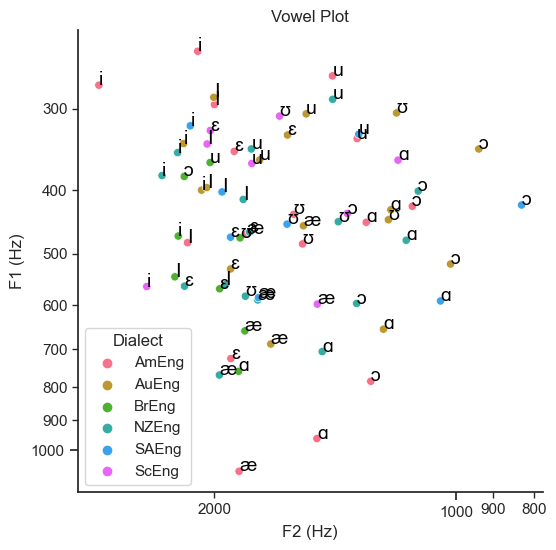

<Axes: title={'center': 'Vowel Plot'}, xlabel='F2 (Hz)', ylabel='F1 (Hz)'>

In [32]:
vowelplot(df, color = 'Dialect')

In [33]:
barkify(df, ["F1","F2"])

,Interval,Label,Start,End,Duration,F1,F2,F3,Source_File,Speaker,Vowel,Dialect,z1,z2
0,2,Segment_1,0.218,0.530,0.312,244.8,2096.7,2810.6,h_d_AmEng1_formants,AmEng1,i,AmEng,2.446727,13.326713
1,4,Segment_2,1.098,1.450,0.352,295.4,1998.6,2687.1,h_d_AmEng1_formants,AmEng1,I,AmEng,2.981428,13.005711
2,6,Segment_3,2.250,2.570,0.320,348.4,1888.2,2692.2,h_d_AmEng1_formants,AmEng1,ɛ,AmEng,3.516354,12.624889
3,8,Segment_4,3.186,3.546,0.360,466.3,1821.8,2604.2,h_d_AmEng1_formants,AmEng1,æ,AmEng,4.622497,12.385135
4,10,Segment_5,4.162,4.498,0.336,447.5,1293.4,2574.8,h_d_AmEng1_formants,AmEng1,ɑ,AmEng,4.453375,10.128405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,8,Segment_4,6.441,6.769,0.328,597.1,1488.1,2593.8,h_d_ScEng_formants,ScEng,æ,ScEng,5.730315,11.040419
68,10,Segment_5,7.785,8.049,0.264,359.4,1180.7,2698.6,h_d_ScEng_formants,ScEng,ɑ,ScEng,3.624313,9.548825
69,12,Segment_6,9.073,9.409,0.336,433.7,1365.2,2791.0,h_d_ScEng_formants,ScEng,ɔ,ScEng,4.327541,10.477161
70,14,Segment_7,10.417,10.633,0.216,307.7,1658.4,2569.6,h_d_ScEng_formants,ScEng,ʊ,ScEng,3.107799,11.757670


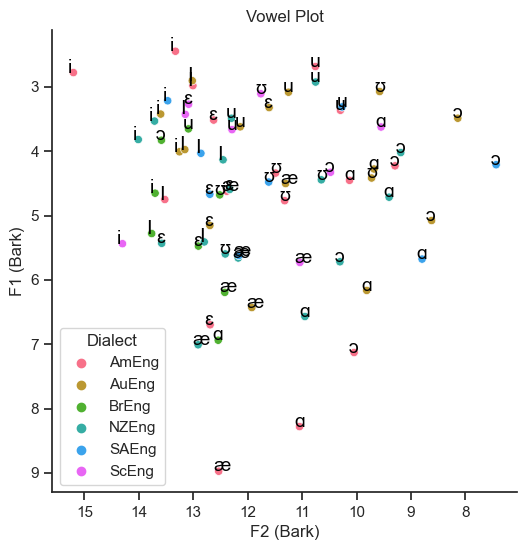

<Axes: title={'center': 'Vowel Plot'}, xlabel='F2 (Bark)', ylabel='F1 (Bark)'>

In [34]:
vowelplot(df,
          F1 = "z1",
          F2 = "z2",
          color = "Dialect",
          unit = "Bark",
          logscale = False)

In [35]:
Lobify(df,
       group = "Speaker",
       formants = ["F1","F2"]
      )

,Interval,Label,Start,End,Duration,F1,F2,F3,Source_File,Speaker,Vowel,Dialect,z1,z2,zsc_F1,zsc_F2
0,2,Segment_1,0.218,0.530,0.312,244.8,2096.7,2810.6,h_d_AmEng1_formants,AmEng1,i,AmEng,2.446727,13.326713,-1.372737,1.260466
1,4,Segment_2,1.098,1.450,0.352,295.4,1998.6,2687.1,h_d_AmEng1_formants,AmEng1,I,AmEng,2.981428,13.005711,-0.799276,0.979806
2,6,Segment_3,2.250,2.570,0.320,348.4,1888.2,2692.2,h_d_AmEng1_formants,AmEng1,ɛ,AmEng,3.516354,12.624889,-0.198615,0.663956
3,8,Segment_4,3.186,3.546,0.360,466.3,1821.8,2604.2,h_d_AmEng1_formants,AmEng1,æ,AmEng,4.622497,12.385135,1.137573,0.473989
4,10,Segment_5,4.162,4.498,0.336,447.5,1293.4,2574.8,h_d_AmEng1_formants,AmEng1,ɑ,AmEng,4.453375,10.128405,0.924508,-1.037740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,8,Segment_4,6.441,6.769,0.328,597.1,1488.1,2593.8,h_d_ScEng_formants,ScEng,æ,ScEng,5.730315,11.040419,1.681138,-0.634368
68,10,Segment_5,7.785,8.049,0.264,359.4,1180.7,2698.6,h_d_ScEng_formants,ScEng,ɑ,ScEng,3.624313,9.548825,-0.463105,-1.387174
69,12,Segment_6,9.073,9.409,0.336,433.7,1365.2,2791.0,h_d_ScEng_formants,ScEng,ɔ,ScEng,4.327541,10.477161,0.207140,-0.935344
70,14,Segment_7,10.417,10.633,0.216,307.7,1658.4,2569.6,h_d_ScEng_formants,ScEng,ʊ,ScEng,3.107799,11.757670,-0.929480,-0.217313


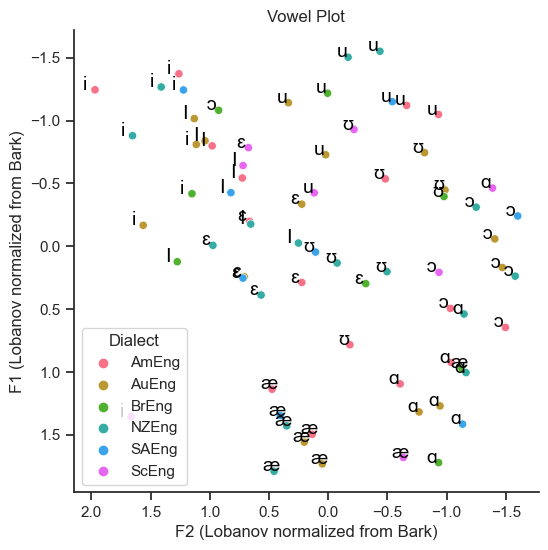

<Axes: title={'center': 'Vowel Plot'}, xlabel='F2 (Lobanov normalized from Bark)', ylabel='F1 (Lobanov normalized from Bark)'>

In [37]:
vowelplot(df,
          F1 = "zsc_F1",
          F2 = "zsc_F2",
          color = "Dialect",
          unit = "Lobanov normalized from Bark",
          logscale = False)